In [85]:
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost as xgb
import sklearn as skl
from sklearn.inspection import DecisionBoundaryDisplay

import time

from mylib import class_distributions
from mylib import data_selection
from mylib import helper_funcs

from mylib.my_xgb import BinaryDecisionTree as BDT
from mylib.my_xgb import add_class


import dtreeviz
import logging
# to suppress messages when plotting trees
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
def plot_decision_boundaries(data, labels, model):
    feature_1, feature_2 = np.meshgrid(
    np.linspace(data.to_numpy()[:, 0].min()-1, data.to_numpy()[:, 0].max()+1),
    np.linspace(data.to_numpy()[:, 1].min()-1, data.to_numpy()[:, 1].max()+1)
    )
    print(feature_1.shape)
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    dgrid = xgb.DMatrix(pd.DataFrame(grid, columns = data.columns))
    y_pred = np.reshape(np.argmax(model.predict(dgrid), axis=1), feature_1.shape)
    print(y_pred[49])
    display = DecisionBoundaryDisplay(
        xx0=feature_1, xx1=feature_2, response=y_pred
    )
    display.plot()

    display.ax_.scatter(
        data.to_numpy()[:, 0], data.to_numpy()[:, 1], c=labels, edgecolor="black"
    )

    plt.show()

In [87]:
model_folder = Path("../models/XOR")

### Das Ziel ist ein XOR-Minimalbeispiel mit 2 Originalklassen und einer neu gelernten Klasse.

# Data generation

In [88]:
np.random.seed(42)

num_points_cluster1 = 24
num_points_cluster2 = 56
num_points_cluster3 = 33
num_points_cluster4 = 14
num_points_cluster5 = 26


# erste Klasse
center1 = [-1.5, 1.5]
center2 = [1, -1]

# zweite Klasse
center3 = [-2, -2]
center4 = [1, 1]

# neue Klasse
center5 = [2, 2]

# create the features of the original data
X_original = np.concatenate([np.random.multivariate_normal(center1, .01*np.identity(2), size=num_points_cluster1),
                             np.random.multivariate_normal(center2, .01*np.identity(2), size=num_points_cluster2),
                             np.random.multivariate_normal(center3, .01*np.identity(2), size=num_points_cluster3),
                             np.random.multivariate_normal(center4, .01*np.identity(2), size=num_points_cluster4)])

y_original = np.concatenate([np.zeros(num_points_cluster1+num_points_cluster2, dtype='int8'),
                             np.ones(num_points_cluster3+num_points_cluster4, dtype='int8')])

X_update = np.random.multivariate_normal(center5, .01*np.identity(2), size=num_points_cluster5)
y_update = 2*np.ones(num_points_cluster5, dtype='int8')

X = pd.DataFrame(np.concatenate([X_original, X_update]), columns = ['x','y'])
labels = pd.Series(np.concatenate([y_original, y_update]))

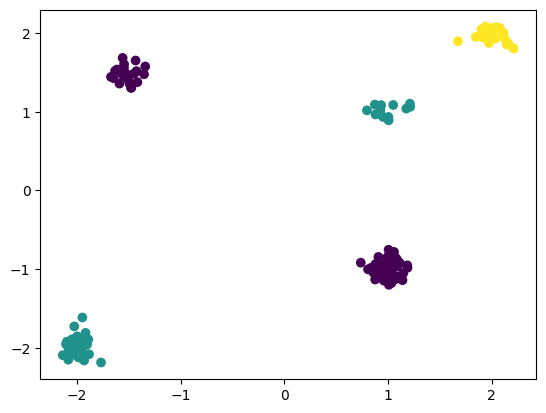

In [89]:
plt.scatter(X.iloc[:,0], X.iloc[:,1], c=labels);

In [90]:
# prepare smaller dataset with only first num_labels classes of beans

old_classes = [0,1]
new_class = 2

# compute number of old labels used
num_labels = len(old_classes)

# relabel for XGBoost
labels = helper_funcs.relabel(labels, old_classes, new_class)

data_small = X[labels < num_labels]
labels_small = labels[labels < num_labels]

# attempt to retrain with new data
new_class_data = X[labels == num_labels]
new_class_labels = labels[labels == num_labels]

# also train a model with all the data availale for comparison
data_full = pd.concat([data_small, new_class_data])
labels_full = pd.concat([labels_small, new_class_labels])

# Train a model

In [91]:
# specify DMatrices

dtrain_small = xgb.DMatrix(data_small, label=labels_small)
dtest_small = xgb.DMatrix(data_small, label=labels_small)

# specify some parameters
num_models = 1
proportion_of_old_data = [i*0.2 for i in range(1,5)]

# specify paramters for XGBoost
num_round = 100
num_round_full = num_round
early_stopping_rounds = num_round*.1
max_depth = 2
eta = .1

param_small = {'max_depth': max_depth, 'eta': eta, 'objective': 'multi:softprob', "num_class": num_labels}
param_small['min_child_weight'] = 0
param_small['nthread'] = 4
param_small['eval_metric'] = 'mlogloss'

evallist_small = [(dtrain_small, 'train'), (dtest_small, 'eval')]

In [92]:
# training model with fewer labels
bst_small = xgb.train(param_small,
                      dtrain_small,
                      num_round,
                      evals=evallist_small,
                      #early_stopping_rounds=early_stopping_rounds,
                      verbose_eval=False)

bst_small.save_model(fname = model_folder / 'small_XOR_model.json')

In [93]:
print("Accuracy on test data: ", skl.metrics.accuracy_score(np.argmax(bst_small.predict(dtest_small), axis=1), labels_small))

Accuracy on test data:  1.0


In [108]:
def plot_decision_boundaries(data, labels, model):
    
    axes = [np.linspace(data.to_numpy()[:, i].min()-1, data.to_numpy()[:, i].max()+1,
                       num = 32) for i in range(data.shape[1])]
    features = np.meshgrid(*axes)
    grid = np.vstack([feature.ravel() for feature in features]).T
    print("grid: ", grid.shape)
    dgrid = xgb.DMatrix(pd.DataFrame(grid, columns = data.columns))
    
    y_pred = np.reshape(np.argmax(model.predict(dgrid), axis=1), features[0].shape)
    
    # PCA
    
    # normalize
    data_normal = (data_full-data_full.min())/(data_full.max()-data_full.min())

    pca = skl.decomposition.PCA(n_components=2)
    pca_features = pca.fit_transform(data_normal.to_numpy())
    pca_grid = pca.transform(grid)
    
    print(pca_grid[:,0].shape)
    print(pca_features.shape)
    print(y_pred.shape)
    
    display = DecisionBoundaryDisplay(
        xx0=np.reshape(pca_grid[:,0], y_pred.shape), xx1=np.reshape(pca_grid[:,1], y_pred.shape), response=y_pred
    )
    display.plot()

    display.ax_.scatter(
        pca_features[:,0], pca_features[:,1], c=labels, edgecolor="black"
    )

    plt.show()

grid:  (1024, 2)
(1024,)
(153, 2)
(32, 32)


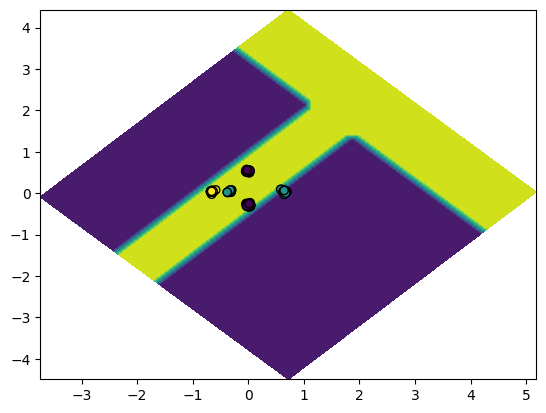

In [110]:
plot_decision_boundaries(data_full, labels_full, bst_small)

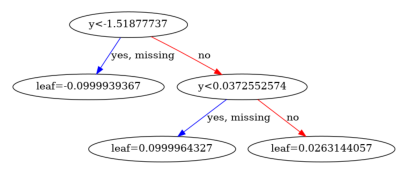

In [ ]:
xgb.plot_tree(bst_small, num_trees=0)
plt.gcf().set_size_inches(5, 3)
#plt.savefig("temp.pdf")
plt.show()

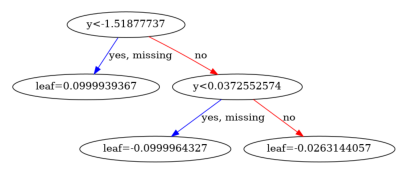

In [12]:
xgb.plot_tree(bst_small, num_trees=1)
plt.gcf().set_size_inches(5, 3)
#plt.savefig("temp.pdf")
plt.show()

In [13]:
bst_small_df = bst_small.trees_to_dataframe()
bst_small_df[bst_small_df["Tree"] == 0]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,y,-1.518777,0-1,0-2,0-1,35381.382800,63500.0,NaN
1,0,1,0-1,Leaf,NaN,NaN,NaN,NaN,-0.099994,16500.0,NaN
2,0,2,0-2,y,0.037255,0-3,0-4,0-3,6145.001950,47000.0,NaN
3,0,3,0-3,Leaf,NaN,NaN,NaN,NaN,0.099996,28000.0,NaN
4,0,4,0-4,Leaf,NaN,NaN,NaN,NaN,0.026314,19000.0,NaN


In [14]:
# specify DMatrices

# only to check performance on the newly added data
dnew_class = xgb.DMatrix(new_class_data, label=new_class_labels)

dtrain_full = xgb.DMatrix(data_full, label=labels_full)
dtest_full = xgb.DMatrix(data_full, label=labels_full) 

In [15]:
# parameters for data_full model

param_full = {'max_depth': max_depth,
              'eta': eta,
              'objective': 'multi:softprob',
              "num_class": num_labels+1}
param_full['nthread'] = 4
param_full['eval_metric'] = 'mlogloss'

evallist_full = [(dtrain_full, 'train'), (dtest_full, 'eval')]

In [16]:
# training a model with all the training data

bst_full = xgb.train(param_full,
                     dtrain_full,
                     num_round_full,
                     evals=evallist_full,
                     #early_stopping_rounds=early_stopping_rounds,
                     verbose_eval=25)

[0]	train-mlogloss:0.98662	eval-mlogloss:0.98662
[9]	train-mlogloss:0.48192	eval-mlogloss:0.48192


In [17]:
print("Accuracy on test data: ", skl.metrics.accuracy_score(np.argmax(bst_full.predict(dtest_full), axis=1), labels_full))

Accuracy on test data:  0.9084967320261438


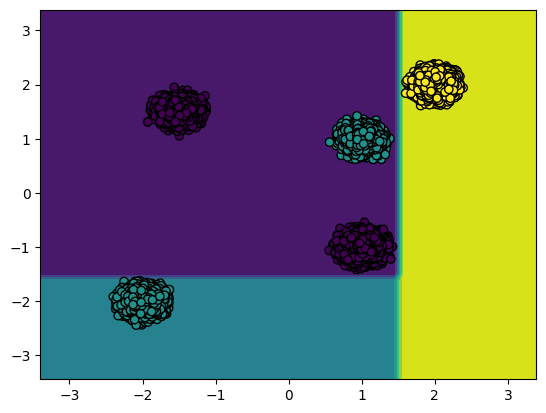

In [18]:
plot_decision_boundaries(data_full, labels_full, bst_full)

In [19]:
# parameters for update model (the same as for full model, but just in case I want to ever change them)

param_update = {'max_depth': max_depth,
                'eta': eta,
                'objective': 'multi:softprob',
                "num_class": num_labels+1}
param_update['nthread'] = 4
param_update['eval_metric'] = 'mlogloss'

In [20]:
# update only with new data

# update model
bst_update = add_class.add_class(model_file = model_folder / 'small_XOR_model.json',
                                 data = pd.concat([new_class_data, new_class_labels], axis=1),
                                 num_tree_grps = num_round,
                                 num_orig_classes = num_labels,
                                 num_iterations = num_round,
                                 params = param_small)

In [21]:
print("Accuracy on test data: ", skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_full), axis=1), labels_full))

Accuracy on test data:  0.16993464052287582


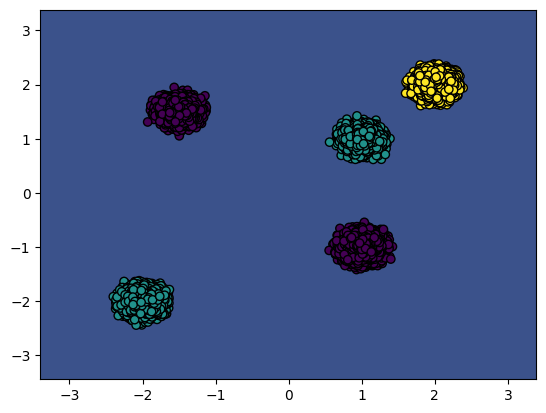

In [22]:
plot_decision_boundaries(data_full, labels_full, bst_update)

In [23]:
random_old = []
random_new = []
random_mixed = []
random_full = []

for proportion in proportion_of_old_data:
    print(f"Current target proportion of old data in use: {proportion}")
        
    random_old_tmp = 0
    random_new_tmp = 0
    random_mixed_tmp = 0
    random_full_tmp = 0

    for _ in range(num_models):

        _, old_data_part, _, old_y_part = skl.model_selection.train_test_split(data_small,
                                                                               labels_small,
                                                                               test_size=proportion)
        

        data_update = pd.concat([old_data_part, new_class_data])
        labels_update = pd.concat([old_y_part, new_class_labels])

        X_train_update, X_test_update, y_train_update, y_test_update = skl.model_selection.train_test_split(data_update,
                                                                                                            labels_update,
                                                                                                            test_size=.2)

        # create DMatrices

        dtrain_update = xgb.DMatrix(X_train_update, label=y_train_update)
        dtest_update = xgb.DMatrix(X_test_update, label=y_test_update)
        
        evallist_update = [(dtrain_update, 'train'), (dtest_update, 'eval')]
        
        # update model
        bst_update = add_class.add_class(model_file = model_folder / 'small_XOR_model.json',
                                         data = pd.concat([X_train_update, y_train_update], axis=1),
                                         num_tree_grps = num_round,
                                         num_orig_classes = num_labels,
                                         num_iterations = num_round,
                                         params = param_small)


        
        random_old_tmp += skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_small), axis=1), labels_small)
        random_new_tmp += skl.metrics.accuracy_score(np.argmax(bst_update.predict(dnew_class), axis=1), new_class_labels)
        random_mixed_tmp += skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_update), axis=1), y_test_update)
        random_full_tmp += skl.metrics.accuracy_score(np.argmax(bst_update.predict(dtest_full), axis=1), labels_full)


    random_old.append(random_old_tmp/num_models)
    random_new.append(random_new_tmp/num_models)
    random_mixed.append(random_mixed_tmp/num_models)
    random_full.append(random_full_tmp/num_models)

Current target proportion of old data in use: 0.2
Current target proportion of old data in use: 0.4
Current target proportion of old data in use: 0.6000000000000001
Current target proportion of old data in use: 0.8


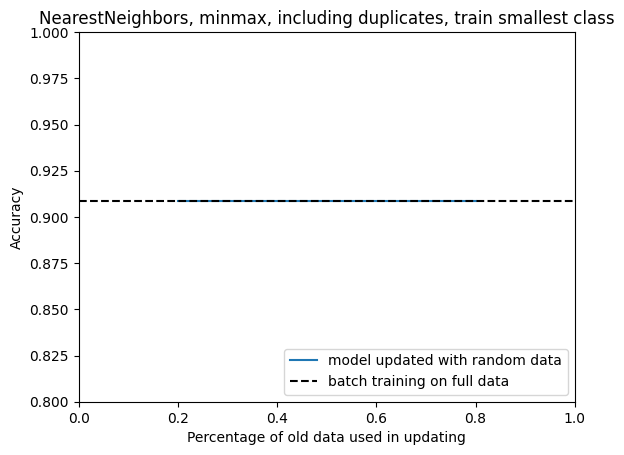

In [25]:
# save the performances
fig = plt.figure()
ax = plt.gca()
ax.set_xlim([0, 1])
ax.set_ylim([0.8, 1])
plt.title(f"NearestNeighbors, minmax, including duplicates, train smallest class")
plt.plot(proportion_of_old_data, random_full, label="model updated with random data")
    
plt.axhline(skl.metrics.accuracy_score(np.argmax(bst_full.predict(dtest_full), axis=1), labels_full),
            color = "black",
            linestyle = "--",
            label = "batch training on full data")
plt.xlabel("Percentage of old data used in updating")
plt.ylabel("Accuracy")
plt.legend(loc=4)
plt.savefig(f"NN, minmax, including duplicates, train smallest class.png")
plt.show();